# Прогнозируем временные ряды продаж товаров
В этом задании предлагается проанализировать датасет продаж различных товаров и построить предсказание на 24 дня вперед с `2018-12-07`.

В ноутбуке содержится ряд вопросов, которые подскажут, на что стоит обратить внимание при прогнозировании. Ответы на них следует оформлять текстом и иллюстрировать кодом/визуализациями.


Подробное описание датасетов содержится в файле `dataset/README.md`.

<b>При выполнении задания нельзя использовать библиотеку etna.</b>
<!-- Кроме самих целевых временных рядов, можно будет использовать исторические данные о проведенных акциях.  
[Подробное описание датасета](https://data.world/data-society/causal-effects-in-time-series) -->

***
# 0. Загрузка датасета
В этой части не нужно писать никакого дополнительного кода.

In [ ]:
!ls dataset

In [1]:
import pandas as pd

# загружаем датасет с продажами продуктов
df_products = pd.read_csv("dataset/products.csv", index_col=0)

# загружаем датасет с рекламными акциями
df_promotions = pd.read_csv("dataset/promotions.csv", index_col=0)

In [243]:
print(f"Датасет с продажами: {df_products.shape}")
print(f"Датасет с акциями: {df_promotions.shape}")

Датасет с продажами: (1071, 30)
Датасет с акциями: (1095, 1000)


In [ ]:
!pip install plotly

### Посмотрим, как выглядят ряды, которые нужно будет спрогнозировать

In [ ]:
from IPython.display import HTML
from IPython.display import display
# Взято https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
Чтобы показать/скрыть данную ячейку кода нажмите <a href="javascript:code_toggle()">здесь</a>.''')
display(tag)

import plotly.express as px
import plotly.graph_objects as go
fig = go.Figure()
for products in df_products.columns[0:10]:
    fig.add_trace(go.Scatter(x=df_products.index, y=df_products[products], name = products))
    fig.update_xaxes(
        tickformat="%b\n%Y")
fig.update_xaxes(rangeslider_visible=True, 
                 title_text = "Дата", 
                 title_standoff = 25, 
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1, label="1м", step="month", stepmode="backward"),
                         dict(count=6, label="6м", step="month", stepmode="backward"),
                         dict(count=1, label="1г", step="year", stepmode="backward"),
                         dict(label="все", step="all")])))
fig.update_yaxes(title_text = "Продажи", title_standoff = 25)
fig.update_layout(title = "Набор временных рядов")
fig.show()

fig = go.Figure()
for products in df_products.columns[20:30]:
    fig.add_trace(go.Scatter(x=df_products.index, y=df_products[products], name = products))
    fig.update_xaxes(
        tickformat="%b\n%Y")
fig.update_xaxes(rangeslider_visible=True, 
                 title_text = "Дата", 
                 title_standoff = 25, 
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1, label="1м", step="month", stepmode="backward"),
                         dict(count=6, label="6м", step="month", stepmode="backward"),
                         dict(count=1, label="1г", step="year", stepmode="backward"),
                         dict(label="все", step="all")])))
fig.update_yaxes(title_text = "Продажи", title_standoff = 25)
fig.update_layout(title = "Набор временных рядов")
fig.show()

fig = go.Figure()
for products in df_products.columns[10:19]:
    fig.add_trace(go.Scatter(x=df_products.index, y=df_products[products], name = products))
    fig.update_xaxes(
        tickformat="%b\n%Y")
fig.update_xaxes(rangeslider_visible=True, 
                 title_text = "Дата", 
                 title_standoff = 25, 
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1, label="1м", step="month", stepmode="backward"),
                         dict(count=6, label="6м", step="month", stepmode="backward"),
                         dict(count=1, label="1г", step="year", stepmode="backward"),
                         dict(label="все", step="all")])))
fig.update_yaxes(title_text = "Продажи", title_standoff = 25)
fig.update_layout(title = "Набор временных рядов")
fig.show()

### Предварительно понятно, что временные ряды обладают ярко-выраженной сезонностью, вероятно коррелируют друг с другом или автокоррелируют. Кроме того, в рядах отсутствует долговременный тренд.

***
# 1. EDA
В этом блоке предлагается изучить исходные данные и ответить на вопросы про них.

## 1.1. Сезонности и тренды
<ol>
    <li>Есть ли в данных явно выраженные тренды?</li>
    <li>Есть ли в данных сезонность? Если есть, то какая? Почему это может быть важно?</li>
</ol>

In [ ]:
# докажем отсутствие тренда првоеркой на стационарность при помощи теста Дики-Фулера
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns   
import math

i,j=0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(df_products.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))

for col in df_products.columns:
    result = adfuller(df_products[col])
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']
    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    axs[i][j].plot(df_products.index, df_products[col], color=linecolor)
    axs[i][j].set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    axs[i][j].set_ylabel(ylabel=col, fontsize=14)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0

plt.tight_layout()
plt.show()


**На 5% уровне значимости можно сказать, что все временные ряды стационарны согласно статистике Дики-Фулера. Нет ни одного красного графика. Это значит, что в данных нет выраженного тренда.**

In [ ]:
# для определения сезонности мы можем провести гармонический анализ с преобразованием Фурье
import heapq
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns   
import math
import numpy as np
lenth_prod = len(df_products.index)
ts_ft=np.abs(np.fft.rfft(df_products['product_10']))
ts_freq = np.fft.rfftfreq(lenth_prod)*lenth_prod
ts = pd.DataFrame(ts_ft, columns = ['ts_ft'])
ts_freq = np.fft.rfftfreq(lenth_prod)
# Посмотрим на топ 10 самых выделяющихся гармоник для каждой переменной

for col in df_products.columns:
    ts_ft=np.abs(np.fft.rfft(df_products[col]))
    ts_freq = np.fft.rfftfreq(lenth_prod)*lenth_prod
    ts = pd.DataFrame(ts_ft, columns = [col])
    print(ts.nlargest(10, col)) 

# можно заметить, что у рядов выделяются частоты на 14-40 дней, что отражает ежемесячную динамику

In [ ]:
# кроме того, для определения сезонности помогут графики автокорреляции 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
i,j=0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(df_products.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))

for col in df_products.columns:
    plot_acf(df_products[col], ax=axs[i][j], lags=600)
    axs[i][j].set_ylabel(ylabel=col, fontsize=14)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0

plt.show()

# в данном случае мы видим, что в рядах есть значимые автокорреляции на разных уровнях: Например product_26
# обладает ежегодной сезонностью, а product_27 полугодовой
# на основании этих данных продукты можно распределить на кластеры, для которых можно обучить отдельные модели

## 1.2. Масштаб
<ol>
    <li> Какой масштаб у рядов? </li>
    <li> Какой разброс значений внутри каждого ряда? </li>
    <li> Может ли это как-то помешать при прогнозировании? </li>
</ol>

In [ ]:
# создадим html отчёт о данных для удобства их просмотра. В отчёте представлены распределения, основные статистики, корреляции
!jupyter nbextension enable --py widgetsnbextension
from pandas_profiling import ProfileReport
report = ProfileReport(df_products, title="Обзор данных", sort="ascending")
report.to_file("ts_report.html")
report # можно заметить, что многие переменные коррелируют друг с другом, как в положительном направлении, так и в отрицательном
# кроме того, не все переменные распределены приближенно по нормальному акону распределения, что говорит о том, что не ко всем из них подойдут стандартные параметрические оценки и нормы стандартизации

In [ ]:
import gc
import sys
import warnings
from joblib import Parallel, delayed
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import heapq
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns   
import math
# построим периодограммы для каждого продукта, чтобы оценить масштаб сезонностей во временных рядах
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="forestgreen")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 12, 52])
    ax.set_xticklabels(
        [
            "Годовой",
            "Полугодовой",
            "Квартальный",
            "Месчный",
            "Недельный",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Спектральная плотность")
    return ax

i,j=0,0
PLOTS_PER_ROW = 3
fig, axs = plt.subplots(math.ceil(len(df_products.columns)/PLOTS_PER_ROW),PLOTS_PER_ROW, figsize=(20, 60))

for col in df_products.columns:
    plot_periodogram(df_products[col], ax=axs[i][j])
    axs[i][j].set_title("Периодограмма "+col)
    j+=1
    if j%PLOTS_PER_ROW==0:
        i+=1
        j=0
# как можно заметить, и как ранее показал график автокорреляций, большинство рядов обладают годовой и полугодовой сезонностью 
# так же есть и месячная сезонность
# тем не менее, необходимо сделать прогноз на 24 дня, поэтому группировать ряды по сезоным мы не будем

In [3]:
import gc
import sys
import warnings
from joblib import Parallel, delayed
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import heapq
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns   
import math

## 1.3. Аномалии
<ol>
    <li>Есть ли в рядах выбросы?</li>
    <li>Как выбросы могут повлиять на прогнозирование?</li>
    <li>Что с ними можно сделать?</li>
</ol>

In [17]:
import gc
import sys
import warnings
from joblib import Parallel, delayed
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import heapq
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns   
import math

In [18]:
import numpy as np
names = list(df_products)
def modify_zscore (df): # для определения выбросов посчитаем модифицированную z-оценку
    # которая показывает распределения исходя из медианы, а не среднего
    # это нужно, потому что не все наши переменные распределены близко к нормальному закону
    median = np.median(df)
    deviation_from_median = np.array(df)-median
    mad = np.median(np.abs(deviation_from_median))
    mod_zscore = (0.6745*deviation_from_median)/(mad)
    return mod_zscore


In [ ]:
import matplotlib.pyplot as plt
import math
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier,DeterministicProcess
from warnings import simplefilter

# визуализируем выбросы для каждого ряда
def plot_anomaly(score_data, threshold, ax, threshold_2):
    score_data = score_data.copy().values
    ranks = np.linspace(1, len(score_data), len(score_data))
    ranks = pd.DataFrame(ranks)
    ranks.index=df_products.index
    mask_outliers = (score_data>threshold)
    mask_outliers_2 = (score_data<threshold_2)
    _, ax = plt.subplots(figsize=(15,6))
    ax.plot(ranks[mask_outliers], score_data[mask_outliers], 'o', color='red', label='Аномалии ')
    ax.plot(ranks[~mask_outliers], score_data[~mask_outliers], 'o', color='forestgreen')
    ax.plot(ranks[mask_outliers_2], score_data[mask_outliers_2], 'o', color='red')
    ax.axhline(threshold, color='red', label='Таргет-линии', alpha=0.5)
    ax.axhline(threshold_2, color='red', alpha=0.5)
    ax.legend(loc='upper right')
    plt.show()

i,j=0,0
for col in df_products.columns:
    plot_anomaly(pd.DataFrame(modify_zscore(df_products[col]), index = df_products.index), 3.5, ax=axs[i][j], threshold_2=-2.5)

In [21]:
# обработка выбросов. Заменим их данными из соответствующих квантилей
for col in df_products.columns:
    score_data = pd.DataFrame(modify_zscore(df_products[col]), index = df_products.index)
    df_products['mask'] = score_data
    df_products[col] = df_products[col].mask(df_products['mask'] > 3.5, df_products[col].quantile(0.95))
    df_products[col] = df_products[col].mask(df_products['mask'] < -2.5, df_products[col].quantile(0.05))

score_data = pd.DataFrame(modify_zscore(df_products['product_25']), index = df_products.index)
df_products['mask'] = score_data
df_products['product_25'] = df_products['product_25'].mask(df_products['mask'] > 3.5, df_products['product_25'].quantile(0.9))
df_products['product_25'] = df_products['product_25'].mask(df_products['mask'] < -2.5, df_products['product_25'].quantile(0.05))

score_data = pd.DataFrame(modify_zscore(df_products['product_36']), index = df_products.index)
df_products['mask'] = score_data
df_products['product_36'] = df_products['product_36'].mask(df_products['mask'] > 3.5, df_products['product_36'].quantile(0.90))
df_products['product_36'] = df_products['product_36'].mask(df_products['mask'] < -2.5, df_products['product_36'].quantile(0.45))
df_products = df_products.drop('mask', axis=1)


In [ ]:
# и снова визуализирум, чтобы убидеиться 
for col in df_products.columns: # что выбросы были преобразованы
    plot_anomaly(pd.DataFrame(modify_zscore(df_products[col]), index = df_products.index), 3.5, ax=axs[i][j], threshold_2=-2.5)

## 1.4. Взаимосвязь рядов
<ol>
    <li>Коррелируют ли ряды между собой?</li>
    <li>Можно ли как-то это использовать? Если да, как? Если нет, почему?</li>
</ol>

### Как мы выяснили ранее во время EDA, определенные ряды коррелируют между собой. 

In [ ]:
# помимо корреляции мы можем оценить, воздействуют ли определенные ряды в прошлом на другие ряды в будущем
# в этом нам поможет тест Гренджера на причинность и Йохансена на коллинеарность
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=25
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
# функция записывает p-уровень значимости теста Гренджера на причинность. Иными словами ряды с малыми значениями (до 0,05)
# могут быть причинами других по принципе столбец_x причина строки_y.
import plotly.express as px

fig = px.imshow(grangers_causation_matrix(df_products, variables = df_products.columns), text_auto=True, aspect="auto")
fig.show()

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05):
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df_products) # можно считать достоверными оценки причинности по Гренджеру для тех переменных
# для которых оценки теста Йохансена = True

In [ ]:
# посмотрим на попарные распределения наших переменных
import scipy.signal as signal
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 

g = sns.pairplot(df_products)

plt.show()

## 1.5. Акции
<ol>
    <li>Что из себя представляет датасет с акциями?</li>
    <li>Как часто происходит каждая акция?</li>
    <li>Рекламная акция для какого-то продукта влияет на его продажи. Может ли она повлиять на продажи других продуктов?</li>
    <li>Есть ли акции, которые пересекаются по времени? Могут ли сразу несколько акций повлиять на один продукт?</li>
</ol>

In [ ]:
!pip install pycausalimpact

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import causalimpact
df_promotions.info() # информация о наборе данных промоакций

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 2016-01-01 to 2018-12-30
Columns: 1000 entries, promotion_0 to promotion_999
dtypes: float64(1000)
memory usage: 8.4+ MB


In [ ]:
# посмотрим на частоту акций во времени
df_promotions.reset_index(inplace=True) 
df_promo = df_promotions.melt(id_vars=['index'],
             var_name = 'name',
             value_name = 'promo') # преобразуем широкие данные в длинные

fig = px.scatter(df_promo, x="index", y="name", color="promo")

fig.update_xaxes(rangeslider_visible=True, 
                 title_text = "Дата", 
                 title_standoff = 25, 
                 rangeselector=dict(
                     buttons=list([
                         dict(count=1, label="1м", step="month", stepmode="backward"),
                         dict(count=6, label="6м", step="month", stepmode="backward"),
                         dict(count=1, label="1г", step="year", stepmode="backward"),
                         dict(label="все", step="all")])))
fig.update_layout(
    autosize=False,
    width=800,
    height=800)
fig.show() 
# как можно заметить, есть множество пересечений, частота промоакций различная, они пересекаются
# отсюда можно сделать вывод, что акции могут воздействовать на несколько продуктов сразу 
# кроме того, фундаментально, не зная природу акций, оценить их воздействие на явно сезонные переменные будет затруднительно, а большого эффекта они не окажут

In [ ]:
def get_redundant_pairs(df):
    '''Без дублирования'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, max, min):
    '''Получим топ коррелируемых переменных'''
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    filtercorr = au_corr[((au_corr >= max) & (au_corr <= min)) | ((au_corr <= - max ) & (au_corr >= - min)) & (au_corr !=1.000)]
    au_corr = filtercorr.unstack(level=0)
    fig = px.imshow(au_corr, text_auto=True, aspect="auto")
    fig.update_layout(font=dict(size=8))
    fig.show()

print("Топ очень высоких корреляций переменных")
get_top_abs_correlations(reshapepromo, 0.9, 0.999999)
print("Топ высоких корреляций переменных")
get_top_abs_correlations(reshapepromo, 0.7, 0.899999)
print("Топ средних корреляций переменных")
get_top_abs_correlations(reshapepromo, 0.5, 0.699999)

In [ ]:
def corr(df1, df2):
    n = len(df1)
    v1, v2 = df1.values, df2.values
    sums = np.multiply.outer(v2.sum(0), v1.sum(0))
    stds = np.multiply.outer(v2.std(0), v1.std(0))
    return pd.DataFrame((v2.T.dot(v1) - sums / n) / stds / n,
                        df2.columns, df1.columns)

reshapepromo = df_promotions[:-24]
reshapepromo = reshapepromo.iloc[:, 1:1001]
df_concat_corr = corr(df_products, reshapepromo)
au_corr = df_concat_corr.unstack()
filtercorr = au_corr[((au_corr >= .6) | (au_corr <= -.6)) & (au_corr !=1.000)]
au_corr = filtercorr.unstack(level=0)
fig = px.imshow(au_corr, text_auto=True, aspect="auto")
fig.update_layout(font=dict(size=8))
print("Топ корреляций переменных")
fig.show()

In [ ]:
def promo_len (df): # как посчитать последоватлеьность длительности акций..?
    

## 1.6. Ваш ход
Может быть, есть еще что-то интересное, чего мы не заметили? :)

***
# 2. Прогнозирование
В этом блоке предлагается построить прогноз на указанный промежуток времени и ответить на вопросы о метриках и валидации результатов.

<i>Возможно, в этом блоке не получится разбить код на предложенные части; в таком случае следует оставить максимально подробный комментарий к происходящему. </i>

In [11]:
HORIZON = 24 # горизонт прогнозирования

## 2.1. Пайплайн прогнозирования
### 2.1.1. Подготовка данных
<ol>
    <li>Нужно ли как-то предобрабатывать ряды из датасета?</li>
    <li>Какие признаки можно выделить из данных?</li>
    <li>Какие признаки можно извлечь из индекса timestamp?</li>
    <li>Как использовать данные об акциях?</li>
    <li>*Есть ли среди выделенных признаков categorical признаки? Если есть, как с ними работать?</li>
</ol>

### 2.1.2. Модель
Какие модели прогнозирования могут помочь в нашей задаче? В чем их особенности, плюсы и минусы?

In [46]:
products = list(df_products.iloc[:,1:30].columns)
promo = list(reshapepromo.columns)
dataset_1 = pd.concat([df_products, reshapepromo], axis = 1) # на случай важных переговоров

In [63]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

TRAIN_SPLIT = 1000
tf.random.set_seed(13)
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

BATCH_SIZE = 256
BUFFER_SIZE = 10000

EVALUATION_INTERVAL = 20
EPOCHS = 10

dataset = df_products.values
dataset = dataset[:TRAIN_SPLIT]

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data).astype('float32'), np.array(labels, dtype=object)

past_history = 900
future_target = 71
STEP = 1

In [68]:
dataset=df_products.values
dataset.shape

(1071, 30)

In [69]:

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             0, TRAIN_SPLIT, past_history,
                                             future_target, STEP)
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (900, 30)

 Target temperature to predict : (71,)


In [85]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi.astype('float32'), y_train_multi.astype('float32')))
train_data_multi = train_data_multi.cache().batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi.astype('float32'), y_val_multi.astype('float32')))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()



In [76]:
train_data_multi

<RepeatDataset element_spec=(TensorSpec(shape=(None, 900, 30), dtype=tf.float32, name=None), TensorSpec(shape=(None, 71), dtype=tf.float32, name=None))>

In [ ]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'purple',
             label='Predicted Future')
        plt.legend(loc='upper left')
    plt.show()
    
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [35]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(71))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)


4/4 [==============================] - 1s 140ms/step
(100, 71)


In [36]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=1)

Epoch 1/10
200/200 [==============================] - 149s 733ms/step - loss: 271615049728.0000 - val_loss: 0.3290
Epoch 2/10
200/200 [==============================] - 153s 766ms/step - loss: 0.3023 - val_loss: 0.2900
Epoch 3/10
200/200 [==============================] - 149s 746ms/step - loss: 0.2759 - val_loss: 0.2625
Epoch 4/10
200/200 [==============================] - 151s 757ms/step - loss: 0.2512 - val_loss: 0.2455
Epoch 5/10
200/200 [==============================] - 147s 737ms/step - loss: 0.2378 - val_loss: 0.2328
Epoch 6/10
200/200 [==============================] - 321s 2s/step - loss: 0.2318 - val_loss: 0.2285
Epoch 7/10
200/200 [==============================] - 153s 764ms/step - loss: 0.2283 - val_loss: 0.2256
Epoch 8/10
200/200 [==============================] - 148s 743ms/step - loss: 0.2256 - val_loss: 0.2238
Epoch 9/10
200/200 [==============================] - 145s 728ms/step - loss: 0.2232 - val_loss: 0.2217
Epoch 10/10
200/200 [==============================] - 1

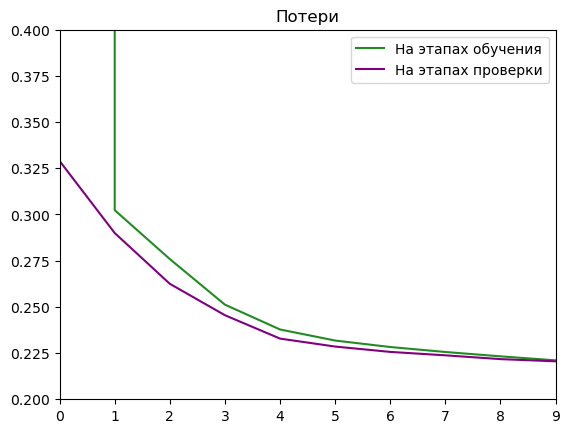

In [45]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'forestgreen', label='На этапах обучения')
    plt.plot(epochs, val_loss, 'purple', label='На этапах проверки')
    plt.title(title)
    plt.legend()
    plt.xlim (0, 9)
    plt.ylim (0.2, 0.4)
    plt.show()

plot_train_history(multi_step_history, 'Потери')

In [ ]:
for x, y in val_data_multi.take(30):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [62]:
train_df,test_df = df_products[1:1000], df_products[1000:] 
n_features = 30
def split_series(series, past_history, future_target):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + past_history
        future_end = past_end + future_target
        if future_end > len(series):
            break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

X_train, y_train = split_series(train_df.values,900, 100)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test_df.values,71, 0)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

array([], dtype=float64)

In [78]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))

In [33]:
val_data_multi.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 900, 30), dtype=tf.float64, name=None), TensorSpec(shape=(None, 71), dtype=tf.float64, name=None))>

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('prod%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('prod%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('prod%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = df_products
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed.index = df_products.iloc[:-1].index
print(reframed.head())

In [39]:
# split into train and test sets
values = reframed.values
train_size = int(0.85 * len(values))
train = values[:train_size, :]
test = values[train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(909, 1, 59) (909,) (161, 1, 59) (161,)


In [52]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((train_X, train_y))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((test_X, test_y))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [53]:
train_data_multi

<RepeatDataset element_spec=(TensorSpec(shape=(None, 1, 59), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [56]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
        plt.legend(loc='upper left')
    plt.show()

def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [298]:
target_column = ['product_10']
train_size = int(0.85 * len(df_products))

multivariate_df = df_products[target_column + products].copy()
multivariate_df.columns = ['y'] + products

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [1,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 0])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [1,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 0])


(910, 5)

In [300]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()



In [306]:
train_data_multi

<RepeatDataset element_spec=(TensorSpec(shape=(None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [303]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:

for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [308]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [ ]:
train_df,test_df = df_products[1:1000], df_products[1000:] 
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s


In [ ]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series): 
            break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

n_past = 929
n_future = 71 
n_features = 30

X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [ ]:
TRAIN_SPLIT = 1000
prodf = df_products[:TRAIN_SPLIT]
data_mean = prodf.mean(axis=0)
data_std = prodf.std(axis=0)
prodf = (prodf-data_mean)/data_std
promodf = reshapepromo[:TRAIN_SPLIT]
train_df = pd.concat([prodf, promodf], axis = 1)
test_df = pd.concat([df_products, reshapepromo], axis = 1)[1000:]



In [ ]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series): 
            break
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

n_past = 1000
n_future = 71 
n_features = 1

X_train_df, y_train_df = split_series(train_df.values,n_past, n_future)
X_train_df = X_train_df.reshape((X_train_df.shape[0], X_train_df.shape[1],n_features))
y_train_df = y_train_df.reshape((y_train_df.shape[0], y_train_df.shape[1], n_features))
X_test_df, y_test_df = split_series(test_df.values,n_past, n_future)
X_test_df = X_test_df.reshape((X_test_df.shape[0], X_test_df.shape[1],n_features))
y_test_df = y_test_df.reshape((y_test_df.shape[0], y_test_df.shape[1], n_features))

In [245]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
    if single_step:
        labels.append(target[i+target_size])
    else:
        labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [ ]:
past_history = 1000
future_target = 71

x_train, y_train = pd.DataFrame(train_df[:past_history, 1]), pd.DataFrame(train_df.iloc[:past_history, 0])
x_valid, y_valid = pd.DataFrame(test_df[:future_target, 1]), pd.DataFrame(test_df.iloc[:future_target, 0])

x_train_single, y_train_single = multivariate_data(train_df, train_df[:, 1], 0, TRAIN_SPLIT, past_history, future_target)

x_val_single, y_val_single = multivariate_data(test, test[:, 1], TRAIN_SPLIT, None, history_size = 71,future_target)

In [12]:
# your code here
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
    end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)


tf.random.set_seed(13)

future_target = 95
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

X_train = df_train.copy()
X_test = df_test.copy()
full_df = pd.concat([X_train, X_test])
full_df.reset_index(drop=True, inplace=True)
X_store = full_df.set_index(['store_nbr', 'family', 'date']).sort_index()
X_prom = (X_store.groupby('date').mean().squeeze())['onpromotion'].to_frame()
av_sales = (X_store.groupby('date').mean().squeeze())['sales'].to_frame()
full_df.head()

## 2.2. Валидация 
### 2.2.1. Метрики
<ol>
    <li>Какие метрики качества могут быть использованы в нашей задаче?</li>
    <li>В качестве метрики качества мы хотим использовать MSE; с какими проблемами мы можем столкнуться?</li>
</ol>

### 2.2.2. Кросс-валидация
Как провести кросс-валидацию?

### 2.2.3. Сравнение моделей
Предположим, мы построили несколько пайплайнов прогнозирования. Как выбрать лучший из них?
<ol>
    <li>В датасете 30 рядов, мы посчитали метрику для каждого из них, но нам надо понять, какой из пайплайнов работает лучше; как это сделать?</li>
    <li>Мы выбрали лучший из пайплайнов; можно ли еще улучшить его? Когда стоит остановиться?</li>
    <li>*Если в предыдущих частях были рассмотрены несколько пайплайнов, какой оказался лучшим? Как выглядит лучший прогноз? (Если выше был рассмотрен один пайплайн, пропустите этот пункт)</li>
</ol>

In [13]:
# your code here

## 2.3. Использование доп данных
<ol>
    <li>Получилось ли использовать данные об акциях при построении прогнозов?</li>
    <li>Если да, помогают ли они предсказывать точнее?</li>
    <li>Как понять, какие из акций важны, а какие нет? Могут ли скоррелированные признаки помешать оценке важности признака? Что с этим делать?</li>
</ol>

In [14]:
# your code here

## 2.4. Production 🚀
Мы построили восхитительный пайплайн прогнозирования! Как вывести его в продакшн?

***
# Свободная часть
Часть для самых смелых энтузиастов в мире временных рядов! 

Здесь предлагается попробовать сделать с датасетом что-то интересное на ваш вкус. Можно попробовать сделать что-то из предложенного:
- Покрутить датасет `dataset/influence.csv`: в нем дана матрица влияния каждой акции на каждый временной ряд продаж. Как ее можно использовать? Как это может помочь при прогнозировании? 
- Поглубже погрузиться в изучение "близости" временнях рядов и попробовать использовать эти знания для прогнозирования
- Подумать о том, как можно оценить влияние какого-то внешнего фактора-признака? Допустим, у нас есть такой же датасет с продажами и мы знаем, что определенная акция должна была повлиять на конкрентный ряд. Как оценить это влияние?
- Любая другая тема, которая кажется важной и интересной

In [15]:
# your code here